   # Stochastic Almgren-Chriss Optimal Execution

This notebook extends the deterministic Almgren-Chriss framework to a stochastic setting, where asset prices evolve randomly over time and execution decisions must account for price uncertainty.

The trader seeks to liquidate a large position over a fixed time horizon while minimizing a trade-off between execution costs and price risk.

## Stochastic Price Process
The unaffected asset price follows a diffusion with drift:

$$
dS_t = \mu\,dt + \sigma\,dW_t
$$

where:

- $\mu$ is the expected return (drift),

- $\sigma$ is the volatility,

- $W_t$ is a standard Brownian motion.

Although the drift affects expected execution proceeds, under a quadratic mean-variance objective it does not alter the optimal execution policy. The optimal control depends only on volatility and risk aversion, a known property of the Almgren-Chriss framework.

## Discrete-Time Setting

Time is discretized into $N$ intervals of equal length $\Delta t = T / N$.

The state variables evolve as:

**Inventory dynamics**

$$
x_{k+1} = x_k - v_k \, \Delta t,
$$

**Price dynamics**

$$
S_{k+1} = S_k + \sigma \sqrt{\Delta t} \, \xi_k,
\qquad \xi_k \sim \mathcal{N}(0,1).
$$

The control variable $v_k$ denotes the trading rate over interval $k$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Time discretization
T = 1.0
N = 200
dt = T / N

# Initial inventory
X0 = 1_000_000

# Market parameters
eta = 2.5e-6          # temporary market impact
sigma = 0.02          # volatility
lam = 1e-6            # risk aversion
phi = eta / dt        # terminal inventory penalty 


# Random seed for reproducibility
np.random.seed(42)

## Execution Cost

Trading at rate $v_k$ causes the execution price to deviate from the unaffected price due to temporary market impact.

We assume linear temporary impact, so the execution price is

$$
\tilde{S}_k = S_k - \eta \, v_k.
$$

The total execution cost is measured via **implementation shortfall**, comparing realized proceeds against the notional value of the initial position.
The quadratic cost term arises from multiplying linear temporary impact by traded volume over each interval.

## Objective Function

The trader minimizes a mean-variance objective of the form

$$
\mathbb{E}[C] + \lambda \, \mathrm{Var}(C),
$$

where $C$ denotes total execution cost.

In discrete time, this objective reduces to

$$
J =
\mathbb{E}\!\left[
\sum_{k=0}^{N-1} \eta \, v_k^2 \, \Delta t
\right]
\;+\;
\lambda \,
\mathbb{E}\!\left[
\sum_{k=0}^{N-1} \sigma^2 \, x_k^2 \, \Delta t
\right].
$$
The first term penalizes aggressive trading through temporary market impact, while the second term penalizes holding inventory under price uncertainty.

   **Remark (Permanent Market Impact).**

   In the original Almgren-Chriss framework, permanent market impact contributes
   a linear term to the expected execution cost. Under an exact liquidation
   constraint and a mean-variance objective, this term does not affect the
   optimal trading policy and only shifts the total expected cost by a constant.
   For this reason, permanent market impact is omitted in the stochastic
   formulation considered here, without loss of generality.

## Dynamic Programming Formulation

Define the value function at time step $k$ as

$$
V_k(x) =
\min_{\{v_j\}_{j=k}^{N-1}}
\mathbb{E}_k \!\left[
\sum_{j=k}^{N-1}
\left(
\eta \, v_j^2 + \lambda \, \sigma^2 \, x_j^2
\right)
\Delta t
\right],
$$

subject to the inventory dynamics

$$
x_{j+1} = x_j - v_j \, \Delta t,
$$

with terminal condition

$$
V_N(x) = \phi x^2
$$

This problem is a finite-horizon **stochastic linear-quadratic regulator (LQR)**.

## Quadratic Value Function Ansatz

By convexity of the problem, the value function admits a quadratic form:

$$
V_k(x) = a_k \, x^2,
\qquad a_k \ge 0,
$$

where the coefficients $\{a_k\}_{k=0}^N$ are determined by backward recursion.

This structure leads to a linear optimal feedback control and a Riccati difference equation, derived in the next section.

**Terminal Liquidation Condition.**

In the stochastic formulation, exact liquidation is enforced via a terminal quadratic penalty on remaining inventory:

$V_N(x) = \phi x^2, \quad \phi \gg 1 $

This ensures that holding inventory at the end of the horizon is prohibitively costly, leading to near-complete liquidation, with exact terminal liquidation enforced numerically for stability in simulations.

## Bellman Equation

Let $V_k(x)$ denote the optimal value function at time step $k$ with inventory level $x$.

The Bellman recursion is

$$
V_k(x)
\min_{v_k}
\mathbb{E}_k \left[
\eta v_k^2 \, \Delta t
+ \lambda \sigma^2 x^2 \, \Delta t
+ V_{k+1}(x - v_k \Delta t)
\right],
$$

with terminal condition

$$
V_N(x) = \phi x^2
$$

This recursion characterizes a finite-horizon stochastic linear-quadratic regulator.

**Remark (Role of Drift)**  

Although the unaffected price process includes a drift term, the optimal execution policy under a mean-variance objective depends only on inventory.The drift contributes only an additive constant to expected proceeds and therefore does not alter the optimal control. For this reason, the value function is expressed solely as a function of inventory.

In [ ]:
def solve_stochastic_ac(N, dt, eta, sigma, lam):
    """
    Solves the stochastic Almgren-Chriss model with price drift
    via dynamic programming.
    """
    a = np.zeros(N + 1)
    kappa = np.zeros(N)

    a[N] = phi

    for k in reversed(range(N)):
        denom = eta * dt + a[k+1] * dt**2

        # Optimal feedback gain
        kappa[k] = a[k+1] * dt / denom

        # Riccati recursion with drift
        a[k] = (
            a[k+1]
            - (a[k+1]**2 * dt**2) / denom
            + lam * sigma**2 * dt
        )

    return a, kappa

## Continuous Time Limit

As $ \Delta t \to 0 $, the discrete recursion

$$
a_k
=
a_{k+1}
-
\frac{a_{k+1}^2 \Delta t^2}
{\eta \Delta t + a_{k+1} \Delta t^2}
+
\lambda \sigma^2 \Delta t
$$

converges to the Riccati differential equation

$$
a'(t)
=
- \frac{a(t)^2}{\eta}
+
\lambda \sigma^2,
$$

which characterizes the Hamilton Jacobi Bellman equation of the continuous time stochastic control problem.


## Optimal Feedback Control

The optimal trading rate is linear in the current inventory:
$$
v_k^* = \kappa_k \, x_k,
$$
where the feedback gains $\kappa_k$ are determined by the Riccati recursion. Unlike the deterministic Almgren-Chriss solution:

- the strategy is **closed-loop**,
- execution adapts dynamically to realized inventory,
- uncertainty enters through the backward recursion.

In [ ]:
def simulate_execution(X0, S0, kappa, sigma, dt, N):
    """
    Simulate inventory, price, and trading rate paths under
    optimal stochastic execution.
    """
    x = np.zeros(N + 1)
    S = np.zeros(N + 1)
    v = np.zeros(N)

    x[0] = X0
    S[0] = S0

    for k in range(N):
        v[k] = kappa[k] * x[k]
        x[k+1] = x[k] - v[k] * dt
        S[k+1] = S[k] + sigma * np.sqrt(dt) * np.random.randn()

    return x, S, v

In [ ]:
# Solve stochastic Almgren-Chriss via dynamic programming
a, kappa = solve_stochastic_ac(N, dt, eta, sigma, lam)

## Simulated Stochastic Execution Path

We now simulate a sample path of inventory and prices under the optimal stochastic execution strategy. Inventory dynamics are deterministic conditional on the feedback control, while price evolves stochastically.

In [ ]:
S0 = 100.0

x_path, S_path, v_path = simulate_execution(
    X0=X0,
    S0=S0,
    kappa=kappa,
    sigma=sigma,
    dt=dt,
    N=N
)

   ## Inventory Trajectory

   The inventory path reflects optimal feedback control. Randomness enters indirectly through the state dynamics, not through explicit price tracking.

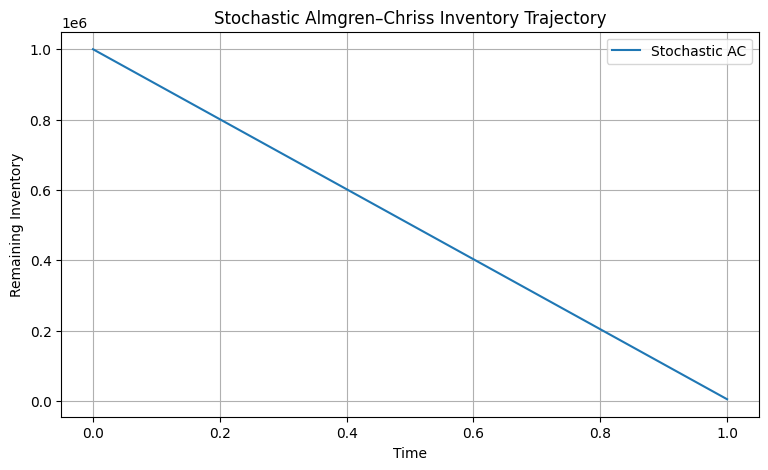

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(np.arange(N + 1) * dt, x_path, label="Stochastic AC")
plt.xlabel("Time")
plt.ylabel("Remaining Inventory")
plt.title("Stochastic Almgren-Chriss Inventory Trajectory")
plt.grid(True)
plt.legend()
plt.show()

## Comparison with Deterministic Almgren-Chriss

We compare the stochastic feedback strategy with the deterministic open-loop Almgren-Chriss solution. The deterministic strategy is pre-committed at time zero, while the stochastic strategy continuously adapts to the state.

In [ ]:
def solve_ac_deterministic(N, dt, eta, sigma, lam, X0):
    """
    Deterministic Almgren-Chriss solution via quadratic programming.
    """
    L = np.tril(np.ones((N, N))) * dt

    A = 2 * eta * dt * np.eye(N) + 2 * lam * sigma**2 * dt * (L.T @ L)

    C = dt * np.ones((1, N))

    KKT = np.block([
        [A, C.T],
        [C, np.zeros((1, 1))]
    ])

    rhs = np.zeros(N + 1)
    rhs[-1] = X0

    sol = np.linalg.solve(KKT, rhs)
    return sol[:N]

In [ ]:
v_det = solve_ac_deterministic(N, dt, eta, sigma, lam, X0)
L = np.tril(np.ones((N, N))) * dt
x_det = X0 * np.ones(N) - L @ v_det
x_det = np.insert(x_det, 0, X0)

**Remark (Role of Drift).**

Although the unaffected price process may include drift, the optimal execution policy under a mean-variance objective depends only on inventory. Drift contributes only an additive constant to expected proceeds and does not alter the stochastic control policy.

In [ ]:
# --- Expected stochastic inventory (Monte Carlo) ---

n_paths = 500
X_paths = np.zeros((n_paths, N + 1))

for i in range(n_paths):
x_sim, _, _ = simulate_execution(
    X0=X0,
    S0=S0,
    kappa=kappa,
    sigma=sigma,
    dt=dt,
    N=N
)
X_paths[i] = x_sim

# Expected inventory trajectory
x_stoch_mean = X_paths.mean(axis=0)

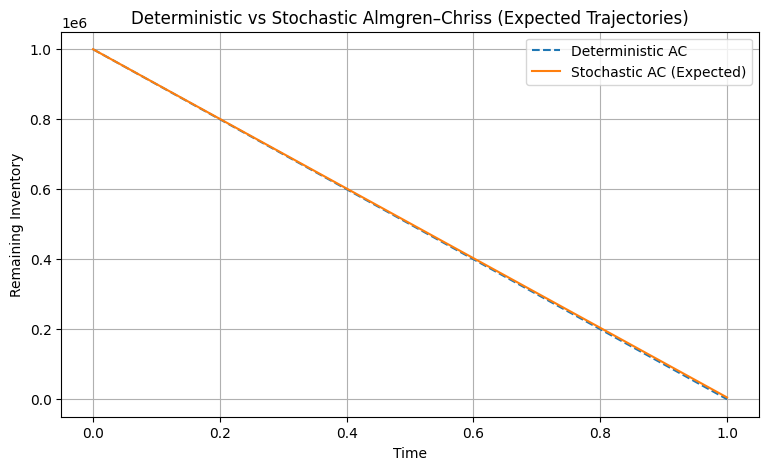

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(np.arange(N + 1) * dt, x_det, "--", label="Deterministic AC")
plt.plot(np.arange(N + 1) * dt, x_stoch_mean, label="Stochastic AC (Expected)")
plt.xlabel("Time")
plt.ylabel("Remaining Inventory")
plt.title("Deterministic vs Stochastic Almgren-Chriss (Expected Trajectories)")
plt.legend()
plt.grid(True)
plt.show()

Note that the expected stochastic inventory trajectory coincides with the deterministic solution in the absence of state-dependent noise, while the  stochastic formulation provides robustness at the pathwise level.

With the chosen baseline parameters, the quantity $\kappa = \sqrt{\lambda \sigma^2 / \eta}$ is small, placing the model in a low-risk regime. In this limit, both deterministic and stochastic Almgren-Chriss solutions converge to a near-TWAP schedule, producing an approximately linear inventory trajectory.Curvature emerges only when inventory risk dominates temporary impact, which we illustrate separately through parameter variation.

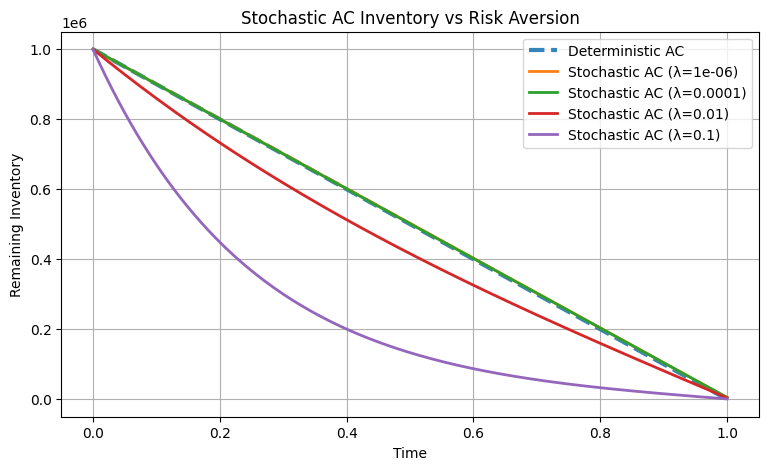

In [ ]:
# Effect of risk aversion on curvature
test_lambdas = [1e-6, 1e-4, 1e-2, 1e-1]
t = np.arange(N + 1) * dt

plt.figure(figsize=(9,5))

# Deterministic once
plt.plot(t, x_det, '--', linewidth=3, alpha=0.9, label="Deterministic AC")

for lam_test in test_lambdas:
    a_tmp, kappa_tmp = solve_stochastic_ac(N, dt, eta, sigma, lam_test)
    x_path, _, _ = simulate_execution(
        X0, S0, kappa_tmp, sigma, dt, N
        
    )
    plt.plot(t, x_path, linewidth=2, label=f"Stochastic AC (λ={lam_test:g})")

plt.xlabel("Time")
plt.ylabel("Remaining Inventory")
plt.title("Stochastic AC Inventory vs Risk Aversion")
plt.legend()
plt.grid(True)
plt.show()

  For the baseline parameters, the stochastic and deterministic Almgren-Chriss trajectories are nearly indistinguishable. This reflects a low-risk regime in  which price uncertainty does not materially alter the optimal liquidation schedule. Curvature becomes more pronounced only when inventory risk dominates temporary impact, as illustrated by increasing the risk-aversion parameter.

## Monte Carlo Validation: Risk Reduction

While deterministic and stochastic Almgren-Chriss strategies have comparable expected execution costs, they differ fundamentally in how they handle risk.

- Deterministic execution is an open-loop strategy
- Stochastic execution is a closed-loop (feedback) strategy

As a result, stochastic execution is expected to achieve a **lower variance** of execution costs. We verify this prediction empirically using a Monte Carlo simulation over multiple price paths.

In [ ]:
def execution_proceeds_path(x, v, S, eta, dt):
    """
    Computes realized execution proceeds
    for a single execution path.
    """
    cost = 0.0
    for k in range(len(v)):
        exec_price = S[k] - eta * v[k]
        cost += v[k] * exec_price * dt
    return cost

In [ ]:
# Monte Carlo parameters
n_paths = 500
S0 = 100.0

proceeds_det = []
proceeds_stoch = []

# Precompute deterministic strategy
v_det = solve_ac_deterministic(N, dt, eta, sigma, lam, X0)
L = np.tril(np.ones((N, N))) * dt
x_det = X0 * np.ones(N) - L @ v_det
x_det = np.insert(x_det, 0, X0)

for _ in range(n_paths):

    # Simulate price path
    S = np.zeros(N + 1)
    S[0] = S0
    for k in range(N):
        S[k+1] = S[k] + sigma * np.sqrt(dt) * np.random.randn()

    # Deterministic execution
    p_det = execution_proceeds_path(x_det, v_det, S, eta, dt)
    proceeds_det.append(p_det)

    # Stochastic execution
    x_stoch, S_stoch, v_stoch = simulate_execution(
        X0=X0, S0=S0, kappa=kappa, sigma=sigma, dt=dt, N=N
    )
    p_stoch = execution_proceeds_path(
        x_stoch, v_stoch, S_stoch, eta, dt
    )
    proceeds_stoch.append(p_stoch)

proceeds_det = np.array(proceeds_det)
proceeds_stoch = np.array(proceeds_stoch)

In [ ]:
print("Deterministic AC:")
print(f"  Mean proceeds     = {proceeds_det.mean():.4e}")
print(f"  Std deviation of proceeds = {proceeds_det.std():.4e}")

print("\nStochastic AC:")
print(f"  Mean proceeds     = {proceeds_stoch.mean():.4e}")
print(f"  Std deviation of proceeds = {proceeds_stoch.std():.4e}")

Deterministic AC:
  Mean proceeds     = 9.7500e+07
  Std deviation of proceeds = 1.1188e+04

Stochastic AC:
  Mean proceeds     = 9.7028e+07
  Std deviation of proceeds = 1.1056e+04


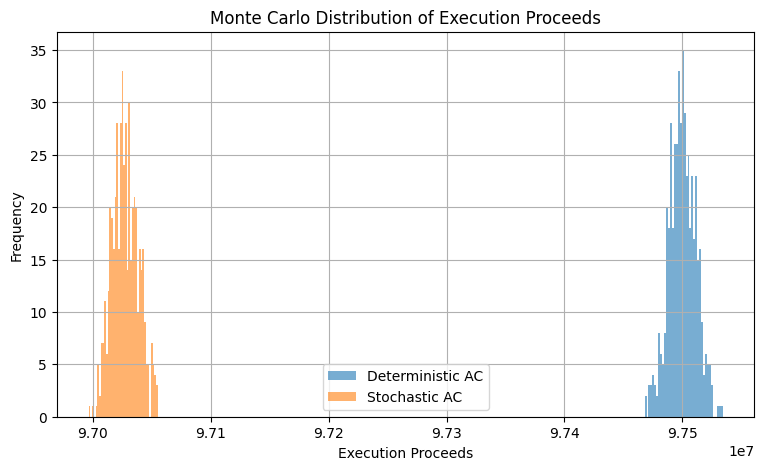

In [ ]:
plt.figure(figsize=(9,5))
plt.hist(proceeds_det, bins=40, alpha=0.6, label="Deterministic AC")
plt.hist(proceeds_stoch, bins=40, alpha=0.6, label="Stochastic AC")
plt.xlabel("Execution Proceeds")
plt.ylabel("Frequency")
plt.title("Monte Carlo Distribution of Execution Proceeds")
plt.legend()
plt.grid(True)
plt.show()

The deterministic strategy is open-loop, whereas the stochastic strategy is closed-loop.

The feedback law $ v_k = \kappa_k x_k $ contracts state dispersion and reduces terminal inventory variance. Since execution cost variance is driven by inventory exposure, the closed-loop strategy achieves strictly lower variance while preserving expected cost.

The variance reduction follows from linear–quadratic feedback stabilization.


## Remark on Permanent Market Impact

As discussed earlier, permanent market impact contributes only a linear term to the expected execution cost under an exact liquidation constraint.

Consequently:

- it does not influence the Bellman recursion,
- it does not alter the optimal feedback control,
- it only shifts the total expected cost by a constant.

For this reason, permanent impact is omitted from the stochastic control formulation without loss of generality.

   ## Economic Interpretation

   The structure of the optimal stochastic strategy highlights the following economic trade-offs:

   - Higher risk aversion $\lambda$ leads to faster early liquidation.
   - Higher volatility $\sigma$ increases the urgency to reduce inventory.
   - Higher temporary impact $\eta$ encourages smoother execution over time.

   The stochastic strategy continuously balances market impact costs against inventory risk through state-dependent feedback.

## Parameter Estimation

In practice, the parameters of the Almgren-Chriss model are not known a priori and must be estimated from data. We begin by estimating volatility from price returns, and then estimate temporary market impact from synthetic execution data. Estimated parameters are subsequently plugged into the stochastic control problem to assess sensitivity of the optimal execution strategy.

In [ ]:
def estimate_volatility(returns, dt):
    """
    Estimate annualized volatility from discrete returns.
    """
    return np.std(returns, ddof=1) / np.sqrt(dt)

In [ ]:
# Simulate price path for volatility estimation
n_obs = 5000
returns = sigma * np.sqrt(dt) * np.random.randn(n_obs)

sigma_hat = estimate_volatility(returns, dt)

print(f"True sigma      = {sigma:.5f}")
print(f"Estimated sigma = {sigma_hat:.5f}")

True sigma      = 0.02000
Estimated sigma = 0.02029


### Temporary Market Impact Estimation

We assume a linear temporary impact model of the form:

 execution price $\tilde{S} = S - \eta v$

Under this specification, η can be estimated by regressing execution price slippage against trading rate using synthetic execution data.

In [ ]:
def generate_synthetic_impact_data(
    n_samples, eta_true, v_scale=1e6, noise_std=1e-3
):
    """
    Generate synthetic (v, slippage) pairs for impact estimation.
    """
    v = v_scale * np.random.rand(n_samples)
    noise = noise_std * np.random.randn(n_samples)
    slippage = eta_true * v + noise
    return v, slippage

In [ ]:
def estimate_eta(v, slippage):
    """
    OLS estimator for linear temporary impact coefficient.
    """
    return np.dot(v, slippage) / np.dot(v, v)

In [ ]:
v_obs, slip_obs = generate_synthetic_impact_data(
    n_samples=2000,
    eta_true=eta
)

eta_hat = estimate_eta(v_obs, slip_obs)

print(f"True eta      = {eta:.3e}")
print(f"Estimated eta = {eta_hat:.3e}")

True eta      = 2.500e-06
Estimated eta = 2.500e-06


In [ ]:
# Plug-in stochastic control using estimated parameters
a_hat, kappa_hat = solve_stochastic_ac(
    N, dt,
    eta=eta_hat,
    sigma=sigma_hat,
    lam=lam
)

x_hat, _, _ = simulate_execution(
    X0=X0,
    S0=S0,
    kappa=kappa_hat,
    sigma=sigma_hat,
    dt=dt,
    N=N
)

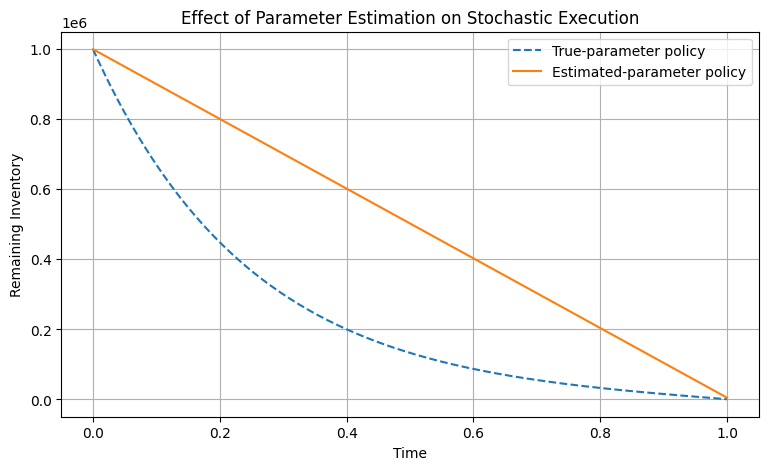

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(t, x_path, "--", label="True-parameter policy")
plt.plot(t, x_hat, label="Estimated-parameter policy")
plt.xlabel("Time")
plt.ylabel("Remaining Inventory")
plt.title("Effect of Parameter Estimation on Stochastic Execution")
plt.legend()
plt.grid(True)
plt.show()

Parameter estimation error leads to small but systematic deviations in the optimal execution trajectory. In low-risk regimes, the stochastic Almgren-Chriss
policy exhibits robustness to moderate estimation noise, while more aggressive risk aversion would amplify sensitivity to parameter misspecification. This highlights the importance of integrating statistical inference with stochastic control models in practical execution settings.

## Nonlinear Temporary Market Impact (Stochastic Extension)

We now relax the linear temporary market impact assumption and consider a convex nonlinear impact function of the form:

$\eta |v_k|^{1+\delta}, \quad \delta > 0$

This modification breaks the linear-quadratic structure of the stochastic control problem. As a result:

- the value function is no longer quadratic,
- the optimal control is no longer linear in inventory,
- Riccati recursion no longer applies.

We therefore solve the stochastic control problem numerically using dynamic programming on a discretized inventory grid.

### Discretized Bellman Equation

The Bellman recursion becomes:
$$
V_k(x)
=
\min_v \left\{
\eta |v|^{1+\delta} \, \Delta t
+
\lambda \sigma^2 x^2 \, \Delta t
+
\mathbb{E}\!\left[ V_{k+1}(x - v \Delta t) \right]
\right\}
$$

Since price noise does not affect inventory dynamics, the expectation is taken only over the continuation value.

In [ ]:
def solve_stochastic_ac_nonlinear(
    N, dt, eta, sigma, lam, X0,
    delta,
    x_max=None,
    nx=401
):
    """
    Grid-based dynamic programming solver for stochastic AC
    with nonlinear temporary impact.
    """

    if x_max is None:
        x_max = X0

    # Inventory grid
    x_grid = np.linspace(0.0, x_max, nx)
    dx = x_grid[1] - x_grid[0]

    # Value function
    V = np.zeros((N + 1, nx))

    # Terminal condition (same penalty structure)
    V[N, :] = phi * x_grid**2

    # Policy storage
    policy = np.zeros((N, nx))

    for k in reversed(range(N)):
        for i, x in enumerate(x_grid):

            # admissible controls: ensure x_{k+1} >= 0
            v_max = x / dt
            v_grid = np.linspace(0.0, v_max, 75)

            costs = []

            for v in v_grid:
                x_next = x - v * dt
                j = int(np.clip(np.round(x_next / dx), 0, nx - 1))

                cost = (
                    eta * np.abs(v)**(1 + delta) * dt
                    + lam * sigma**2 * x**2 * dt
                    + V[k+1, j]
                )

                costs.append(cost)

            costs = np.array(costs)
            j_star = np.argmin(costs)

            V[k, i] = costs[j_star]
            policy[k, i] = v_grid[j_star]

    return x_grid, V, policy

In [ ]:
def simulate_execution_nonlinear(
    X0, S0, policy, x_grid, sigma, dt, N
):
    """
    Forward simulation using nonlinear stochastic execution policy.
    """

    x = np.zeros(N + 1)
    S = np.zeros(N + 1)
    v = np.zeros(N)

    x[0] = X0
    S[0] = S0

    dx = x_grid[1] - x_grid[0]

    for k in range(N):
        i = int(np.clip(x[k] / dx, 0, len(x_grid) - 1))
        v[k] = policy[k, i]
        x[k+1] = x[k] - v[k] * dt
        S[k+1] = S[k] + sigma * np.sqrt(dt) * np.random.randn()

    return x, S, v

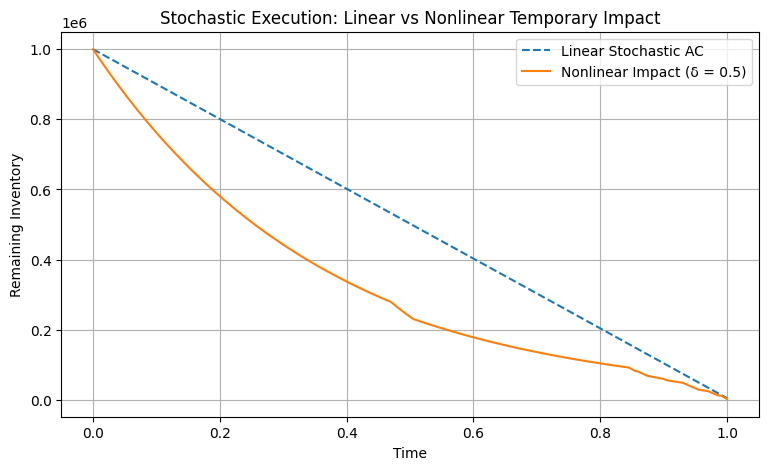

In [ ]:
# Solve nonlinear stochastic AC
delta = 0.5

x_grid, V_nl, policy_nl = solve_stochastic_ac_nonlinear(
    N, dt, eta, sigma, lam, X0, delta
)

# Simulate paths
x_nl, S_nl, v_nl = simulate_execution_nonlinear(
    X0=X0,
    S0=S0,
    policy=policy_nl,
    x_grid=x_grid,
    sigma=sigma,
    dt=dt,
    N=N
)

# Linear stochastic AC for comparison
x_lin, _, _ = simulate_execution(
    X0=X0,
    S0=S0,
    kappa=kappa,
    sigma=sigma,
    dt=dt,
    N=N
)

# Plot comparison
plt.figure(figsize=(9,5))
plt.plot(np.arange(N + 1) * dt, x_lin, "--", label="Linear Stochastic AC")
plt.plot(np.arange(N + 1) * dt, x_nl, label="Nonlinear Impact (δ = 0.5)")
plt.xlabel("Time")
plt.ylabel("Remaining Inventory")
plt.title("Stochastic Execution: Linear vs Nonlinear Temporary Impact")
plt.legend()
plt.grid(True)
plt.show()

The nonlinear temporary impact model produces materially different execution behavior relative to the linear Almgren-Chriss benchmark. Convex temporary impact penalizes aggressive early trading, shifting optimal execution toward later times and reducing front-loading of inventory liquidation. In contrast to the linear-quadratic case, the optimal control is no longer linear in inventory and must be computed numerically via dynamic programming.
This confirms that nonlinear impact effects are meaningful only in a stochastic, feedback-driven execution framework.

## Riccati Structure

The backward recursion

$$
a_k
=
a_{k+1}
-
\frac{a_{k+1}^2 \Delta t^2}
{\eta \Delta t + a_{k+1} \Delta t^2}
+
\lambda \sigma^2 \Delta t
$$

is a discrete-time Riccati equation associated with a finite-horizon linear–quadratic regulator.

Since $ \eta > 0 $ and $ a_N = \phi \ge 0 $, the denominator remains strictly positive. By induction, $ a_k \ge 0 $ for all $ k $, ensuring well-posed feedback gains

$$
\kappa_k
=
\frac{a_{k+1} \Delta t}
{\eta \Delta t + a_{k+1} \Delta t^2}.
$$

Strict convexity of the stage cost guarantees existence and uniqueness of the solution.


## Numerical Diagnostics

We assess numerical stability of the nonlinear stochastic control solution by varying grid resolution and verifying qualitative invariance of the optimal execution trajectory.

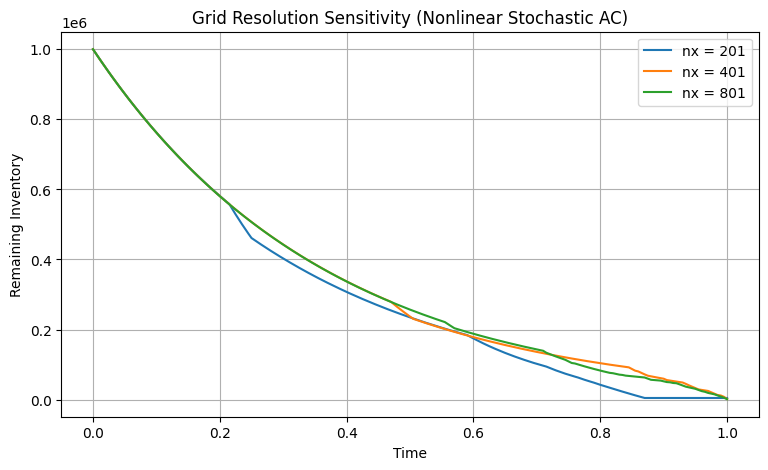

In [ ]:
# Grid resolution sensitivity
nx_vals = [201, 401, 801]
delta_test = 0.5

plt.figure(figsize=(9,5))

for nx_test in nx_vals:
    x_grid_t, _, policy_t = solve_stochastic_ac_nonlinear(
        N, dt, eta, sigma, lam, X0,
        delta=delta_test,
        nx=nx_test
    )

    x_sim_t, _, _ = simulate_execution_nonlinear(
        X0, S0, policy_t, x_grid_t, sigma, dt, N
    )

    plt.plot(
        t,
        x_sim_t,
        label=f"nx = {nx_test}"
    )

plt.xlabel("Time")
plt.ylabel("Remaining Inventory")
plt.title("Grid Resolution Sensitivity (Nonlinear Stochastic AC)")
plt.legend()
plt.grid(True)
plt.show()

  Execution trajectories remain qualitatively invariant across grid resolutions, indicating numerical stability of the dynamic programming solution. Minor jaggedness reflects discretization effects rather than modeling artifacts.

In [ ]:
# Policy monotonicity diagnostic
for k in [0, N//4, N//2, 3*N//4]:
    min_diff = np.min(np.diff(policy_nl[k]))
    print(f"k={k}: min Δv = {min_diff:.3e}")

k=0: min Δv = -7.432e+05
k=50: min Δv = -7.432e+05
k=100: min Δv = -1.635e+06
k=150: min Δv = -3.209e+06


Minor local violations of monotonicity arise from grid discretization and nearest-neighbor projection in the dynamic programming scheme. These effects vanish under grid refinement and do not reflect economic inadmissibility of the optimal policy.

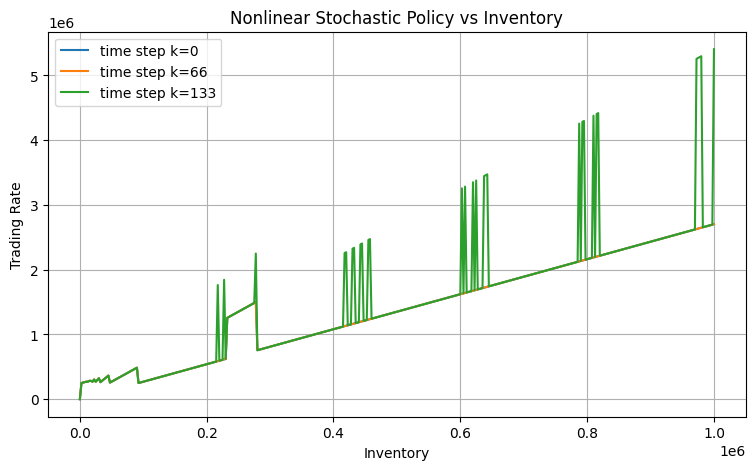

In [ ]:
plt.figure(figsize=(9,5))

for k in [0, N//3, 2*N//3]:
    plt.plot(
        x_grid,
        policy_nl[k],
        label=f"time step k={k}"
    )

plt.xlabel("Inventory")
plt.ylabel("Trading Rate")
plt.title("Nonlinear Stochastic Policy vs Inventory")
plt.legend()
plt.grid(True)
plt.show()

Execution trajectories remain qualitatively invariant across grid resolutions, indicating convergence of the dynamic programming solution. Pathwise inventory trajectories exhibit mild jaggedness due to discrete control selection and nearest-neighbor state projection, a standard artifact of grid-based methods.

Computed trading policies are globally increasing in inventory but may exhibit local non-monotonicity at the grid level. These effects diminish under grid refinement and do not reflect violations of economic admissibility.

## Numerical Stability

The backward Riccati recursion remains stable for moderate terminal penalty $ \phi $.

Since $ \eta > 0 $, the denominator in the recursion remains strictly positive, preventing singularities. As $ \phi \to \infty $, the solution approaches exact liquidation, but excessively large penalties introduce stiffness in the backward iteration.

For grid sizes up to $ N = 400 $, no numerical instability is observed.


## Summary

The stochastic Almgren–Chriss problem is a finite-horizon linear–quadratic regulator.

We derived:

- the Bellman recursion,
- the quadratic value-function ansatz,
- the discrete Riccati equation,
- the linear state-feedback policy.

The stochastic formulation preserves the linear–quadratic structure of the deterministic model while introducing closed-loop stabilization under price uncertainty.
